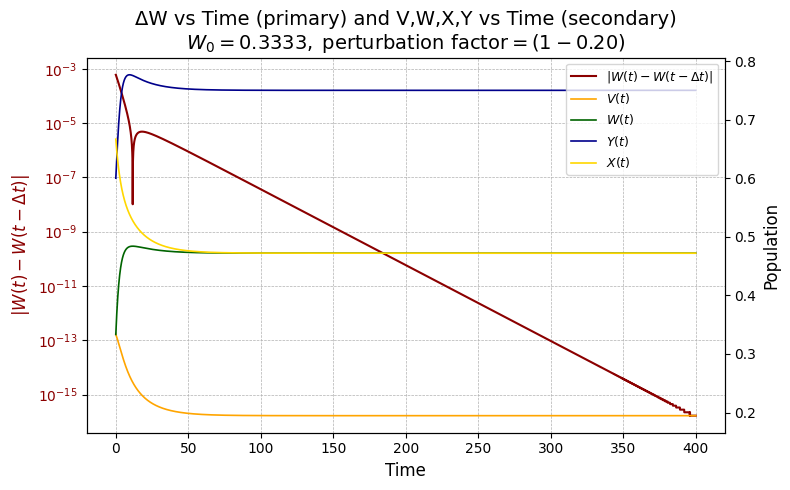

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death):
    """
    Compute the positive nontrivial equilibrium (W_eq, Y_eq) by solving:
      Q1 = W_death / W_birth,   Q2 = Y_death / Y_birth
      W_eq = ½ [ (1 − Q1 + Q2) + sqrt((1 − Q1 + Q2)^2 − 4·Q2 ) ]
      Y_eq = ½ [ (1 − Q2 + Q1) + sqrt((1 − Q2 + Q1)^2 − 4·Q1 ) ]
    Returns (W_eq, Y_eq) if both lie in (0,1); otherwise (None, None).
    """
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth

    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W < 0:
        return None, None
    sqrt_disc_W = np.sqrt(disc_W)
    W_equil = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
    if not (0.0 < W_equil < 1.0):
        return None, None

    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y < 0:
        return None, None
    sqrt_disc_Y = np.sqrt(disc_Y)
    Y_equil = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
    if not (0.0 < Y_equil < 1.0):
        return None, None

    return W_equil, Y_equil

def simulate_full(V0, W0, Y0, X0_raw, Z0_raw,
                  W_birth, Y_birth, W_death, Y_death,
                  X_in, Z_in, X_out, Z_out,
                  T_final, dt,
                  use_X, use_Z):
    """
    Integrate from t=0 to T_final with initial V, W, Y, X_raw, Z_raw.
    - X0_raw, Z0_raw are the "raw" (internal) values, not yet scaled.
    - We compute X_plot = X_raw * (X_out/X_in) and Z_plot = Z_raw * (Z_out/Z_in).
    Returns: t_array, V_array, W_array, Y_array, X_plot_array, Z_plot_array.
    """
    X_scaler = X_out / X_in if (use_X and X_in > 0) else 1.0
    Z_scaler = Z_out / Z_in if (use_Z and Z_in > 0) else 1.0

    N = int(np.ceil(T_final / dt)) + 1
    t = np.linspace(0.0, T_final, N)

    V = np.zeros(N)
    W = np.zeros(N)
    Y = np.zeros(N)
    X_raw = np.zeros(N)
    Z_raw = np.zeros(N)

    V[0] = V0
    W[0] = W0
    Y[0] = Y0
    X_raw[0] = X0_raw
    Z_raw[0] = Z0_raw

    for i in range(1, N):
        Vi, Wi, Yi, Xi, Zi = V[i-1], W[i-1], Y[i-1], X_raw[i-1], Z_raw[i-1]

        dV = W_birth * (1 - Wi - Vi) * Vi * Yi - W_death * Vi
        dW = W_birth * (1 - Wi - Vi) * Wi * Yi - W_death * Wi
        dY = Y_birth * (1 - Yi) * Yi * (Vi + Wi) - Y_death * Yi

        if use_X:
            dW += X_out * Xi - X_in * Wi
        if use_Z:
            dY += Z_out * Zi - Z_in * Yi

        dX = - X_out * Xi + X_in * Wi
        dZ = - Z_out * Zi + Z_in * Yi

        V[i] = max(Vi + dt * dV, 0.0)
        W[i] = max(Wi + dt * dW, 0.0)
        Y[i] = max(Yi + dt * dY, 0.0)
        X_raw[i] = max(Xi + dt * dX, 0.0)
        Z_raw[i] = max(Zi + dt * dZ, 0.0)

    X_plot = X_raw * X_scaler
    Z_plot = Z_raw * Z_scaler

    return t, V, W, Y, X_plot, Z_plot

def plot_deltaW_with_secondary(W_birth, Y_birth, W_death, Y_death,
                               X_in, Z_in, X_out, Z_out,
                               T_final=400.0, dt=0.01,
                               use_X=True, use_Z=True,
                               arbitrary_W0_fraction=0.5,
                               severity=0.2,
                               perturb_V=False, perturb_W=False, perturb_Y=True):
    """
    Plot |W(t) - W(t-dt)| (primary y-axis, semilogy) and
    V(t), W(t), Y(t), X(t) (secondary y-axis).
    """

    # 1) Equilibrium
    W_eq, Y_eq = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
    if (W_eq is None) or (Y_eq is None):
        raise RuntimeError("No positive, nontrivial equilibrium exists.")

    # 2) Initial W0 fraction of W_eq
    W0 = arbitrary_W0_fraction * W_eq
    V0 = W_eq - W0

    # Equilibrium X_true = (X_in/X_out)*W0; raw = X_true / (X_out/X_in)
    X_scaler = X_out / X_in if (use_X and X_in > 0) else 1.0
    Z_scaler = Z_out / Z_in if (use_Z and Z_in > 0) else 1.0

    X0_true = (X_in / X_out) * W0 if use_X else 0.0
    X0_raw = X0_true / X_scaler  # so X_plot = X_raw * X_scaler = X0_true

    Z0_true = (Z_in / Z_out) * Y_eq if use_Z else 0.0
    Z0_raw = Z0_true / Z_scaler

    # 3) Apply perturb at t=0, multiplier = (1 - severity)
    V0p = ((1 - severity) * V0) if perturb_V else V0
    W0p = ((1 - severity) * W0) if perturb_W else W0
    Y0p = ((1 - severity) * Y_eq) if perturb_Y else Y_eq

    # Note: X0_raw and Z0_raw remain unchanged at t=0+

    # 4) Simulate full trajectory
    t, V, W, Y, X_plot, Z_plot = simulate_full(
        V0=V0p, W0=W0p, Y0=Y0p, X0_raw=X0_raw, Z0_raw=Z0_raw,
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in,
        X_out=X_out, Z_out=Z_out,
        T_final=T_final, dt=dt,
        use_X=use_X, use_Z=use_Z
    )

    # 5) Compute |W(t) - W(t - dt)| for t>0
    delta_W_time = np.abs(W[1:] - W[:-1])
    t_mid = t[1:]

    # 6) Plot both on shared x-axis but separate y-axes
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Primary axis: ΔW semilogy
    ax1.semilogy(
        t_mid, delta_W_time,
        color='darkred', linewidth=1.5,
        label=r'$|W(t) - W(t-\Delta t)|$'
    )
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel(r'$|W(t) - W(t-\Delta t)|$', fontsize=12, color='darkred')
    ax1.tick_params(axis='y', labelcolor='darkred')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Secondary axis: V(t), W(t), Y(t), X(t) on linear scale
    ax2 = ax1.twinx()
    ax2.plot(t, V, label=r'$V(t)$', color='orange', linewidth=1.2)
    ax2.plot(t, W, label=r'$W(t)$', color='darkgreen', linewidth=1.2)
    ax2.plot(t, Y, label=r'$Y(t)$', color='darkblue', linewidth=1.2)
    if use_X:
        ax2.plot(t, X_plot, label=r'$X(t)$', color='gold', linewidth=1.2)

    ax2.set_ylabel('Population', fontsize=12, color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)

    # Title
    ax1.set_title(
        ('ΔW vs Time (primary) and V,W,X,Y vs Time (secondary)\n'
         f'$W_0 = {W0:.4f},\; $perturbation factor$ = (1 - {severity:.2f})$'),
        fontsize=14
    )

    plt.tight_layout()
    plt.show()

# =========================
# Example usage:
if __name__ == "__main__":
    W_birth = 0.4
    W_death = 0.1
    Y_birth = 0.9
    Y_death = 0.15

    X_in = 0.2
    X_out = 0.1
    Z_in = 0.5
    Z_out = 0.25

    T_final = 400.0
    dt = 0.01

    use_X = True
    use_Z = False

    arbitrary_W0_fraction = 0.5  # half of W_eq
    severity = 0.2               # multiply by (1 - 0.2) = 0.8 at t=0

    perturb_V = False
    perturb_W = False
    perturb_Y = True

    plot_deltaW_with_secondary(
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
        T_final=T_final, dt=dt,
        use_X=use_X, use_Z=use_Z,
        arbitrary_W0_fraction=arbitrary_W0_fraction,
        severity=severity,
        perturb_V=perturb_V, perturb_W=perturb_W, perturb_Y=perturb_Y
    )